In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        """生成具有特定形状的正态分布随机数，并将其初始化为较小的值"""

        return torch.randn(size=shape, device=device) * 0.01

    def three():
        """生成三个参数：输入到隐藏状态的权重矩阵、隐藏状态到隐藏状态的权重矩阵和隐藏状态的偏置项"""

        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆单元
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]

    for param in params:
        param.requires_grad_(True)  # 梯度计算
    return params

In [2]:
def init_lstm_state(batch_size, num_hiddens, device):
    """初始隐状态，初始记忆元"""
    
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens),device=device))

In [3]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state  # 隐状态，记忆元
    outputs = []  # 存储每个时间步的输出
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)  # 输入门
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)  # 遗忘门
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)  # 输出门
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)  # 候选记忆元
        C = F * C + I * C_tilda  # 更新记忆元
        H = O * torch.tanh(C)  # 更新隐藏状态
        Y = (H @ W_hq) + b_q  # 输出计算
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H, C)  # 输出结果和更新后的隐藏状态和记忆元

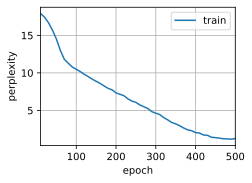

In [4]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
# 传入词汇表大小、隐藏单元数量、设备、参数初始化函数、初始状态函数和 LSTM 模型函数
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)       
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
# perplexity 1.1, 21153.4 tokens/sec on cuda:0
# time traveller redestinn deand whych a lalsediniun and said the 
# traveller whin the medical man there are balloonsbut before